## Exploratory Data Analysis of H1B-LCA Petitions

### Background

   The H1-B visa application is a highly competitive application process that rewards 85,000 applicants per year with an H1B visa out of approximately 650,000 applications annually.  An H1B visa is a temporary work visa granted to foreign workers.  It is commonly given to individuals who have just finished their bachelors or post graduate degrees.  A preliminary step needed to apply for the H1B visa is to apply for an H1B-LCA which is done by the employer.  

   The H1B-LCA application's main goal is to ensure that the employer is providing fair work conditions for the foreign born worker who is applying for the H1B compared to a citizen who would be applying for the same job.  The H1B-LCA application contains information that pertain solely to the employer, not the employee.  An application varies in many categories such as job title, employer name, prevailing wage, and worksite city.   The goal is to predict the outcome of the H1B-LCA application in order to inform an employer what they can change in their application to increase acceptance rate.  Currently there is not a published deterministic cause for application rejection but we hope to find a relationship between responses to certain fields of the application to application outcome.  

   The goal of the this EDA notebook is to go field by field and identify which fields contain values that may be predictors for application outcome.  If the field may be a predictor because its values display a type of correlation to application outcome, we can feed the values into a predictive model.  The dataset involves all of the H1B-LCA applications from fiscal year 2017.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import dill
import warnings
warnings.filterwarnings('ignore')

df=pd.read_csv('cleaned.csv', low_memory=False)


FileNotFoundError: File b'cleaned.csv' does not exist

### Data Set

The dataset was downloaded from, https://www.foreignlaborcert.doleta.gov/performancedata.cfm.  The dataset consists of more than 600,000 data points.  The data labels are divided into 4 classes: (1) Certified (2) Denied (3) Withdrawn (4) Certified Withdrawn.  In the data wrangling step, the withdrawn application were removed because this action was taken by the employer and does not result in an application outcome determined by the Department of Labor.  

In [ ]:
pd.set_option('display.max_columns', 500)
df.head(5)

### Key Fields

A selected number of fields are described below so that interpretation of the dataset above is easier.  The full description of all fields is shown in the url below.

• EMPLOYER_NAME: Name of employer submitting
labor condition application.


• SOC_NAME: Occupational name associated with
the SOC CODE which is an occupational code
associated with the job being requested for temporary
labor condition, as classified by the Standard
Occupational Classification (SOC) System.

• JOB_TITLE: Title of the job

• PREVAILING_WAGE: Prevailing Wage for the job being requested
for temporary labor condition. The wage is listed
at annual scale in USD. The prevailing wage for
a job position is defined as the average wage paid
to similarly employed workers in the requested
occupation in the area of intended employment.
The prevailing wage is based on the employers
minimum requirements for the position.

• FULL_TIME_POSITION: Y = Full Time Position; N =
Part Time Position

• WORK_SITE: City and State information of the
applicant’s intended area of employment in USA

Description of all fields in dataset can be found here: https://www.foreignlaborcert.doleta.gov/pdf/PerformanceData/2017/H-1B_FY17_Record_Layout.pdf

### Field by Field Analysis

#### 1.) Application Outcome

The goal is to predict application outcome.  The application count for each type of application outcome was determined and shown in the graph below.  It is evident, that the dataset is highly imbalanced towards certified applications.  A smaller sample of the certified applications may need to be taken when comparing to the denied applications so that the machine learning model has a more balanced dataset.  

In [ ]:
case_status=df.groupby('CASE_STATUS').count()['CASE_SUBMITTED']
ax = case_status.plot.bar(rot=0)
plt.ylabel('Application Count')
plt.title('Number of Applications by Application Result')

The applications that are labeled with a certfied-withdrawn status are still certified but later withdrawn by the employer when the employer decides not to hire the applicant.  The certified-withdrawn applicants can be treated as certified and were relabeled as certified.

The acceptance rate for applications once this relabeling occurred was 98.6%.  With the relabeling of certified withdrawn applications, the imbalance between certified and denied is increased as seen in the graph below.

In [ ]:
df['CASE_STATUS'] = df['CASE_STATUS'].replace({'CERTIFIED-WITHDRAWN':'CERTIFIED'})
case_status=df.groupby('CASE_STATUS').count()['CASE_SUBMITTED']
ax = case_status.plot.bar(rot=0)
plt.ylabel('Application Count')
plt.title('Number of Applications by Application Result')

d = {'Application Status': case_status.index, 'Count': case_status, 'Percentage of Total Applications': case_status/sum(case_status)*100}
application_status = pd.DataFrame(data=d)
application_status=application_status.reset_index(drop = True)

print(application_status)

#### 2.) Employer Name

The top employers that submit H1B-LCA applications each submit at least 5,000 applications with a maximum of just over 20,000 submitted. This maximum application count is claimed by Infosys Limited.  

In [ ]:
top_employers=df.groupby('EMPLOYER_NAME').count().sort_values(by='CASE_SUBMITTED', ascending=False).head(10)['CASE_STATUS']
ax = top_employers.plot.barh()
plt.xlabel('Application Count')
plt.title('Top 10 Employers with most H1B-LCA Applications')

The wordcloud below depicts the top employers by application count.  It is interesting to see that technology and consultancy companies are the majority of the top employers per application count.

In [ ]:
from wordcloud import WordCloud
top_employers=df.groupby('EMPLOYER_NAME').count().sort_values(by='CASE_SUBMITTED', ascending=False)['CASE_STATUS']
top_employers_dict=top_employers.to_dict()
 



wordcloud = WordCloud(background_color='white',max_font_size = 50)
wordcloud.generate_from_frequencies(frequencies=top_employers)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The mean application count per employer is 8.56 applications while the standard deviation is 128.79 applications.  This means that the company with the 10th most applications per employer, Microsoft, is an astounding 39 standard deviations away from the mean.  The large companies in this dataset take up a disproportionate amount of applications submitted. 

In [ ]:
top_employers=df.groupby('EMPLOYER_NAME').count().sort_values(by='CASE_SUBMITTED', ascending=False)['CASE_STATUS']
print('The mean application count per employer is ' + str(round(np.mean(top_employers), 2)))
print('The standard deviation of application count per employer is ' + str(round(np.std(top_employers), 2)))

In order to fully see the extent of how far apart the top employers were from the mean of population, a cumulative distribution function was created below that describes the fraction of values that are below a certain application count.  For example, according to the graph, if a company with 5000 submitted applications was compared to other companies, it would have more applications than approximately 100% of the applications.  Microsoft has the 10th most applications and is in the 100.0th percentile for applications submitted by a company.  

In [ ]:
def ecdf(data):
    
    n=len(data)

    x=np.sort(data)

    y = np.arange(1, n+1) / n

    return x, y

x, y = ecdf(top_employers)
plt.plot(x, y, marker='.', linestyle='none')
plt.xlabel('Number of Applications')
plt.ylabel('Cumulative probability')
plt.title('Empirical Cumulative Distribution Function of the Number of Applicants')


There are 70,537 unique Employer-names in the H1B-LCA dataset. The different employers  were sorted according to their acceptance rates.  The acceptance rate is defined as the number of accepted applications per employer over the total number of applications per employer.  From the figure below we see that employer vs acceptance rate is not a uniform distribution.  And hence, it can be a good predictor of case-status in our prediction task.

Text(0,0.5,'Acceptance Rate')

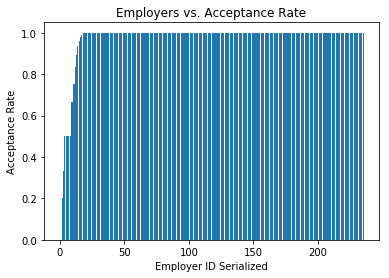

In [23]:
equiv = {'CERTIFIED':1, 'DENIED': 0}
df["CASE_STATUS_INDICATOR"] = df["CASE_STATUS"].map(equiv)
employer_name=df.groupby('EMPLOYER_NAME').mean()['CASE_STATUS_INDICATOR'].sort_values().tolist()[0::300]
x=range(len(employer_name))
plt.bar(x, employer_name)
plt.title('Employers vs. Acceptance Rate')
plt.xlabel('Employer ID Serialized')
plt.ylabel('Acceptance Rate')

#### 3.) Agent Representation

The agent representation field specifies whether the employer entered Yes, No, or None when asked if they have an attorney representing them.  The majority of applications responded with Yes, meaning they have an attorney.  The None value means the employer left the field in the application blank because they did not wish to respond.  

Text(0.5,1,'Number of Applications by Agent Representation')

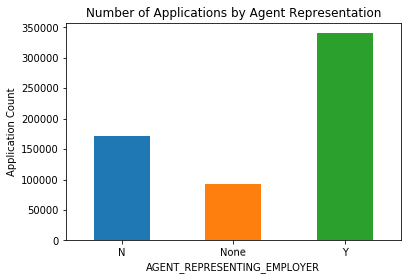

In [10]:
attorney=df.groupby('AGENT_REPRESENTING_EMPLOYER').count()['CASE_SUBMITTED']
ax = attorney.plot.bar(rot=1)
plt.ylabel('Application Count')
plt.title('Number of Applications by Agent Representation')

The graph below juxtaposes the certified and denied application count for each response to agent representation.  The graph below illustrates that all responses have above a 98% acceptance rate.  It is important to note that the No response had a 98.28% acceptance rate, the lowest, possibly because it specifies that there was no attorney.  The None response had the second highest acceptance rate with 98.38% acceptance rate, the second lowest but an improvement, because there is a possibility there is an attorney.  The Yes response had the highest acceptance rate with a 98.82% acceptance rate, because there was an attorney present.  Because rate of acceptance is non uniform for the response to agent respresentation, it can be used a predictor in the prediction task.

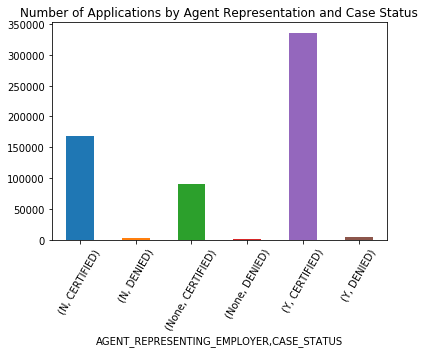

In [11]:
attorney_acceptance=df.groupby(['AGENT_REPRESENTING_EMPLOYER', 'CASE_STATUS']).count()['CASE_NUMBER']
plt.title('Number of Applications by Agent Representation and Case Status')
ax=attorney_acceptance.plot.bar(rot=60)

In [12]:
attorney_acceptance
print('Yes acceptance rate is ' + str(336048/(4028+336048)))
print('None acceptance rate is ' + str(90794/(1495+90794)))
print('No acceptance rate is ' + str(168556/(168556+2957)))

Yes acceptance rate is 0.9881555887507498
None acceptance rate is 0.9838008863461518
No acceptance rate is 0.982759324366083


#### 4.) Occupation Code & Job Title

The occupation code field gives more information regarding the type of work that the employer will be providing as opposed to agent representation which does not give information about the type of work offered.  The main goal of the H1B-LCA application is to ensure fair work conditions.  Some job occupations have more unfair work conditions than others and the acceptance rate of each occupation should be non uniform.  The graph below summarizes the top occupation codes.  It is apparent that the top occupation codes are inhabited by technology related roles such as a software developer and computer systems analyst.   

Text(0.5,1,'Top 10 Occupation Codes with most H1B-LCA Applications')

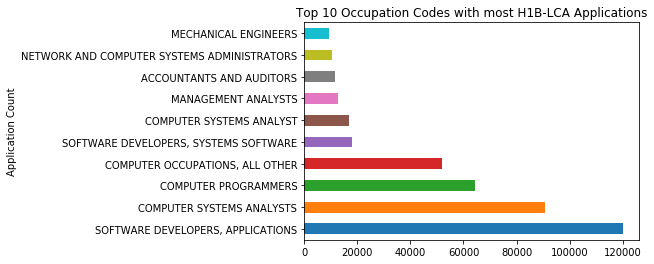

In [13]:
soc_name=df.groupby('SOC_NAME').count().sort_values(by='CASE_SUBMITTED', ascending=False).head(10)['CASE_STATUS']
ax = soc_name.plot.barh()
plt.ylabel('Application Count')
plt.title('Top 10 Occupation Codes with most H1B-LCA Applications')

The wordcloud below depicts the top employers by application count.  It is interesting to see that technology related occupations are the majority of the top occupations per application count.

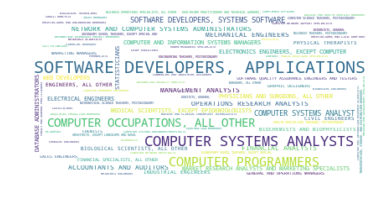

In [14]:
soc_name=df.groupby('SOC_NAME').count().sort_values(by='CASE_SUBMITTED', ascending=False)['CASE_STATUS']

soc_name_dict=soc_name.to_dict()
 



wordcloud = WordCloud(background_color='white',max_font_size = 50)
wordcloud.generate_from_frequencies(frequencies=soc_name_dict)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Occupation titles were ordered by acceptance rate.  The tables below consist of 10 randomly chosen occupation codes from the occupation codes that have a 0% and 100% acceptance rate respectively.  It is apparent that the occupations with a 0% acceptance rate are service jobs that do not necessarly need a technical degree while a majority of applications with a 100% acceptance rate are highly technical positions such as computer programmer, civil engineer, and energy engineer.

In [15]:
soc_name_acc=df.groupby('SOC_NAME').mean()['CASE_STATUS_INDICATOR'].sort_values()

soc_name_den=soc_name_acc.head(9)
soc_name_acc_head=soc_name_acc.tail(10)
soc_name_acc_head=soc_name_acc_head[:-1]


d = {'SOC_NAME': soc_name_den.index, 'Acceptance Rate': soc_name_den}
application_status = pd.DataFrame(data=d)
application_status=application_status.reset_index(drop = True)

print(application_status)

d = {'SOC_NAME': soc_name_acc_head.index, 'Acceptance Rate': soc_name_acc_head}
application_status = pd.DataFrame(data=d)
application_status=application_status.reset_index(drop = True)

print(application_status)


                                         SOC_NAME  Acceptance Rate
0                               HOME HEALTH AIDES              0.0
1                                COOKS, ALL OTHER              0.0
2                                     FILE CLERKS              0.0
3                        FOOD PREPARATION WORKERS              0.0
4  HAIRDRESSERS, HAIRSTYLISTS, AND COSMETOLOGISTS              0.0
5                     MANICURISTS AND PEDICURISTS              0.0
6                                        CASHIERS              0.0
7  MORTICIANS, UNDERTAKERS, AND FUNERAL DIRECTORS              0.0
8        NURSING AIDES, ORDERLIES, AND ATTENDANTS              0.0
                                       SOC_NAME  Acceptance Rate
0                           COMPUTER PROGRAMMER              1.0
1           MEDICAL AND HEALTH SERVICES MANAGER              1.0
2                     COMPUTER SYTSEMS ANALYSTS              1.0
3  MEDICAL AND CLINICAL LABORATORY TECHNOLOGIST              1.0
4   M

There are 862 unique occupation codes in the H1B-LCA dataset.  There are more unique job titles than occupation codes because each occupation code can have many job titles and this is seen in the fact that the unique job title count is at 91,646, approximately 100x greater than occupation code count.  The different occupation codes and job titles  were sorted according to their acceptance rates.  The acceptance rate is defined as the number of accepted applications per occupation/job titles over the total number of applications per occupation/job title.  From the figure below we see that occupation vs acceptance rate and job title vs acceptance rate is not a uniform distribution.  And hence, occupation and job title can be a good predictor of case status in our prediction task.

Text(0,0.5,'Acceptance Rate')

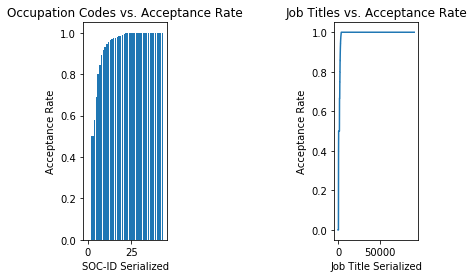

In [32]:
plt.subplot(1,2,1)
soc_name_rate=df.groupby('SOC_NAME').mean()['CASE_STATUS_INDICATOR'].sort_values().tolist()[::20]
x=range(len(soc_name_rate))
plt.bar(x, soc_name_rate)
plt.title('Occupation Codes vs. Acceptance Rate')
plt.xlabel('SOC-ID Serialized')
plt.ylabel('Acceptance Rate')

plt.subplot(1,2,2)
plt.subplots_adjust(wspace=2)

job_title_rate=df.groupby('JOB_TITLE').mean()['CASE_STATUS_INDICATOR'].sort_values().tolist()
x=range(len(job_title_rate))
plt.plot(x, job_title_rate)
plt.title('Job Titles vs. Acceptance Rate')
plt.xlabel('Job Title Serialized')
plt.ylabel('Acceptance Rate')

#### 5.) Industry

Similar to job title, industry gives job specific and company specific information.  The majority of industries with the most H1B-LCA applications are computer related.  The custom computer programming services sector has more than 1/3 of the applications submitted

In [ ]:
soc_name=df.groupby('NAICS_CODE').count().sort_values(by='CASE_SUBMITTED', ascending=False).head(10)['CASE_STATUS']
ax = soc_name.plot.barh()
plt.ylabel('Application Count')
plt.title('Top 10 Industries with most H1B-LCA Applications')

There are 1544 indsutries in the H1B-LCA dataset.  The different industries  were sorted according to their acceptance rates.  The acceptance rate is defined as the number of accepted applications per industry over the total number of applications per industry.  From the figure below we see that industry vs acceptance rate is not a uniform distribution.  And hence, it can be a good predictor of case status in our prediction task.

In [ ]:
job_title_rate=df.groupby('NAICS_CODE').mean()['CASE_STATUS_INDICATOR'].sort_values().tolist()
x=range(len(job_title_rate))
plt.plot(x, job_title_rate)
plt.title('Industry vs. Acceptance Rate')
plt.xlabel('Industry Serialized')
plt.ylabel('Acceptance Rate')

#### 6.) Prevailing Wage

The prevailing wage is the average wage in a metropolitan statistical area code.  The metropolitan statistical area code is defined by the department of labor and is on a scale smaller than that of a county.  The prevailing wage distribution is shown below.  The maximum height of the distribution is \$55,910.  The prevailing wage is not normally distributed but the distribution falls in the vicinity of the mode of the field.  

In [ ]:
prevailing_wage=df[df['PREVAILING_WAGE']<1000000]['PREVAILING_WAGE'].tolist()
sns.distplot(prevailing_wage, color="m")
plt.xlabel('Prevailing Wage')
plt.ylabel('Probability Density')
plt.title('Probability Density of Prevailing Wage')

stats.normaltest(prevailing_wage)

In [ ]:
print(stats.mode(prevailing_wage))

There are many outliers for the prevailing wage.  In the first graph on left below, all prevailing wages vs acceptance rates were graphed.  It is seen that any prevailing past the red line at 0.5e8 has an acceptance rate of 0.0.  Prevailing wages on the order of 1e8 were removed in order to see a how the points less than 1e8 were distributed.  We can see from the second scatter plot that the acceptance rates are not uniform and thus can be a good predictor for the case status prediction task.  A pearson correlation value could not be esablished for data in either graphs below as there is no correlation due to outliers with values much higher than the majority of the data.

In [ ]:
from matplotlib.pyplot import figure
from scipy.stats import pearsonr
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')


plt.subplot(1,2,1)
prevailing_wage_acc=df.groupby('PREVAILING_WAGE').mean()['CASE_STATUS_INDICATOR'].sort_values()
x=prevailing_wage_acc.index
ax.xaxis.labelpad = 50
plt.scatter(x, prevailing_wage_acc)
plt.title('Prevailing Wage vs. Acceptance Rate')
plt.xlabel('Prevailing Wage')
plt.ylabel('Acceptance Rate')
plt.axvline(x=0.3e8, linewidth=2, color='r')

print(pearsonr(x, prevailing_wage_acc))

plt.subplot(1,2,2)
plt.subplots_adjust(wspace=2)

prevailing_wage_acc=df[df['PREVAILING_WAGE']<1000000].groupby('PREVAILING_WAGE').mean()['CASE_STATUS_INDICATOR'].sort_values()
x=prevailing_wage_acc.index
plt.scatter(x, prevailing_wage_acc)
plt.title('Prevailing Wage<1e6 vs. Acceptance Rate')
plt.xlabel('Prevailing Wage')
plt.ylabel('Acceptance Rate')


print(pearsonr(x, prevailing_wage_acc))


 There is significant overlap between the distribution of prevailing wage for accepted and denied applications.  The distribution colored in red for the denied applications can barely be seen behind the distribution for the accepted applications in purple because the of the prevailing wage overlap.  The mean for the prevailing wage of accepted applications is \$77,295 while the mean of the prevailing wage for denied applications is slightly smaller with a mean of \$77,273.

In [ ]:
plt.subplot(1,1,1)

x=df[(df['CASE_STATUS_INDICATOR']==0) & (df['PREVAILING_WAGE']<2000000)]
y=df[(df['CASE_STATUS_INDICATOR']==1) & (df['PREVAILING_WAGE']<2000000)]

sns.distplot(x['PREVAILING_WAGE'], hist=True, kde=True, color='r', label='Denied')
plt.subplot(1,1,1)
sns.distplot(y['PREVAILING_WAGE'], hist=True, kde=True, color='m', label='Certified')
plt.legend(loc='upper right')
plt.title('Prevailing Wage of Accepted vs Denied Applications (Density Plot)')

In [ ]:
print(np.mean(x['PREVAILING_WAGE']))
print(np.mean(y['PREVAILING_WAGE']))

#### 7.) Wage Offered by Employer

The wage offered by the employer is the minimum wage that the employer is willing to pay the employee.  The wage offered distribution is shown below.  The maximum height of the distribution is $60,000.  The prevailing wage is not normally distributed but the distribution falls in the vicinity around the mode of the field.  

In [ ]:
wage_offered=df['WAGE_RATE_OF_PAY_FROM'].tolist()
sns.distplot(prevailing_wage, color="m")
plt.xlabel('Wage Offered')
plt.ylabel('Probability Density')
plt.title('Probability Density of Wage Offered')
stats.normaltest(prevailing_wage)

In [ ]:
print(stats.mode(wage_offered))

 There are many outliers for the wage offered.  In the first graph on the left below, all wage offered vs acceptance rates were graphed.  Wages offered on the order of 1e6 or higher were removed in order to see a how the points less than 1e7 were distributed.  We can see from the second scatter plot that the acceptance rates are not uniform and thus can be a good predictor for the case status prediction task.  A pearson correlation value could not be esablished for data in either graphs below as there is no correlations due to outliers with values much higher than the majority of the data.

In [ ]:
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
from scipy.stats import pearsonr
plt.subplot(1,2,1)


wage_offered_acc=df.groupby('WAGE_RATE_OF_PAY_FROM').mean()['CASE_STATUS_INDICATOR'].sort_values()
x=wage_offered_acc.index
plt.scatter(x, wage_offered_acc)
plt.title('Wage Offered vs. Acceptance Rate')
plt.xlabel('Wage Offered')
plt.ylabel('Acceptance Rate')

print(pearsonr(x,wage_offered_acc))

plt.subplot(1,2,2)
plt.subplots_adjust(wspace=2)

wage_offered_acc=df[df['WAGE_RATE_OF_PAY_FROM']<1e6].groupby('WAGE_RATE_OF_PAY_FROM').mean()['CASE_STATUS_INDICATOR'].sort_values()
x=wage_offered_acc.index
plt.scatter(x, wage_offered_acc)
plt.title('Wage Offered<1e6 vs. Acceptance Rate')
plt.xlabel('Wage Offered')
plt.ylabel('Acceptance Rate')

print(pearsonr(x,wage_offered_acc))

There is significant overlapt between the distribution of offered wage for accepted and denied applications.  The distribution colored in red for the denied applications can barely be seen behind the distribution for the accepted applications in purple because the of the wage offered overlap.  The mean for the prevailing wage of denied applications is \$81,450 while the mean of the prevailing wage for denied applications is slightly larger with a mean of \$87,801.

In [ ]:
plt.subplot(1,1,1)

x=df[(df['CASE_STATUS_INDICATOR']==0) & (df['WAGE_RATE_OF_PAY_FROM']<2000000)]
y=df[(df['CASE_STATUS_INDICATOR']==1) & (df['WAGE_RATE_OF_PAY_FROM']<2000000)]

sns.distplot(x['WAGE_RATE_OF_PAY_FROM'], hist=True, kde=True, color='r')
plt.subplot(1,1,1)
sns.distplot(y['WAGE_RATE_OF_PAY_FROM'], hist=True, kde=True, color='m')
plt.title('Wage Offered of Accepted vs Denied Applications (Density Plot)')

In [ ]:
print(np.mean(x['WAGE_RATE_OF_PAY_FROM']))
print(np.mean(y['WAGE_RATE_OF_PAY_FROM']))

#### 8.) Wage Difference

Wage difference is a calculated field that was thought to possibly be a predictor for application outcome.  A sign of an unfair work condition is if the wage offered to a foreign worker is less than the prevailing wage.  The wage difference field is the difference between the wage offered and the prevailing wage.  Below is a graph of wage difference vs. acceptance rate.  Negative wage differences appear to have a very low acceptance rate, close to 0.0% percent across all negative values.  Two out of 2012 negative wage difference applications are accepted while the other 2010 applications applications were rejected.  Applications with a negative wage difference have a 99.9 percent rejection rate.  Wage difference seems to be a very strong indicator for application outcome. 


In [ ]:
wage_diff=df.groupby('WAGE_DIFFERENCE').mean()['CASE_STATUS_INDICATOR'].sort_values()
x=wage_diff.index.sort_values()
wage_diff=wage_diff.sort_values()
plt.plot(x, wage_diff)
plt.title('Wage Difference vs. Acceptance Rate')
plt.xlabel('Wage Difference')
plt.ylabel('Acceptance Rate')

In [ ]:
print(len(df[(df['WAGE_DIFFERENCE']<0) & (df['CASE_STATUS_INDICATOR']==1)]))
print(len(df[(df['WAGE_DIFFERENCE']<0) & (df['CASE_STATUS_INDICATOR']==0)]))


The density plot below of wage difference between denied and accepted applications below confirms that accepted applications do not tend to have a negative wage difference.

In [ ]:
plt.subplot(1,1,1)

x=df[(df['CASE_STATUS_INDICATOR']==0) & (df['WAGE_DIFFERENCE']<100000) & (df['WAGE_DIFFERENCE']>-100000)]['WAGE_DIFFERENCE'].tolist()
y=df[(df['CASE_STATUS_INDICATOR']==1) & (df['WAGE_DIFFERENCE']<100000)]['WAGE_DIFFERENCE'].tolist()

x=[i for i in x if i==i]
y=[j for j in y if j==j]

sns.distplot(x, hist = True, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label='Denied')
sns.distplot(y, hist = True, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label='Accepted')
plt.title('Wage Difference of Accepted vs Denied Applications (Density Plot)')
plt.legend(loc='upper right')
plt.title.labelpad = 5000

#### 9.) Prevailing Wage Difference 

The prevailing wage listed in the application may be a cause for rejection if it is not reasonably close to the prevailing wage listed in OFLC online wage library.  In order to use the prevailing wage library, we need a metropolitan statistical area code (MSA), prevailing wage level, prevailing wage year, and an occupation code.  Our dataset contains an occupation code, prevailing wage level, and prevailing wage year, but not the MSA.  The following three cells maps the zip code listed in the dataset to an MSA which is then used to retrieve the database prevailing wage and eventually compute the prevailing wage difference.  Table joins were utilized to merge zip code with state and county code, then all the MSAs in a county code and state combination were merged because there are multiple MSAs per per state and county code, and then finally the prevailing wage in the database was found by using the MSAs found from joining, the occupation code, and year from the original table, to find the mean prevailing wage for each unique occupation code, year, wage level, and state/county no. in the database.  The prevailing wage difference is defined as the difference between the prevailing wage in database and the prevailing wage offered.  

407339 applications out of 603878 applications had a wage difference that could be mapped due to a missing value or incorrect value in the joining on columns that could not be reconciled. The majority of missing or incorrect values for the zip code mapping came from the zipcode, county, and state fields in 125,385 applications.  The other, 71,154 applications contained an MSA number that did not have a matching county and state field.  To summarize, the missing or incorrect value could have been in the zip code, wage level, wage year, state name, county code, MSA number, or prevailing wage fields. 

In [ ]:
df_pw=df[['CASE_NUMBER', 'CASE_STATUS', 'SOC_CODE', 'PREVAILING_WAGE', 'PW_WAGE_LEVEL', 'PW_SOURCE_YEAR', 'WORKSITE_POSTAL_CODE']]
df_pw.head(5)

zipcode_to_county_state=pd.read_csv('zipcode_to_county_state.csv', low_memory=False)
zipcode_to_county_state.head(20)

zipcode_to_county_state = zipcode_to_county_state.iloc[9:]
zipcode_to_county_state.columns=zipcode_to_county_state.iloc[0]
zipcode_to_county_state=zipcode_to_county_state.rename(columns={"ZIP CODE": "WORKSITE_POSTAL_CODE"})
zipcode_to_county_state=zipcode_to_county_state.iloc[10:]
zipcode_to_county_state.head(5)

zipcode_to_county_state1=pd.merge(df_pw, zipcode_to_county_state, on='WORKSITE_POSTAL_CODE', how='inner')
zipcode_to_county_state1=zipcode_to_county_state1.drop(['MSA No.', 'GPCI', 'nan'], axis=1)
zipcode_to_county_state1
zipcode_to_county_state1=zipcode_to_county_state1[(zipcode_to_county_state1['PW_WAGE_LEVEL']==zipcode_to_county_state1['PW_WAGE_LEVEL']) & (zipcode_to_county_state1['PW_WAGE_LEVEL']!='None') & (zipcode_to_county_state1['PW_SOURCE_YEAR']==zipcode_to_county_state1['PW_SOURCE_YEAR']) & (zipcode_to_county_state1['PW_SOURCE_YEAR']!='None') & (zipcode_to_county_state1['County No.']==zipcode_to_county_state1['County No.'])]
zipcode_to_county_state1

county_to_msa_=pd.read_csv('area_definitions_m2017.csv', low_memory=False)
county_to_msa_=county_to_msa_.drop(['FIPS code', 'State', 'MSA name (including MSA divisions)', 'Township code', 'County name (or Township name for the New England states)', 'MSA code for MSAs with divisions', 'MSA name for MSAs with divisions'], axis=1)
county_to_msa_=county_to_msa_.rename(columns={"State abbreviation": "STATE", "County code": "County No."})
zipcode_to_county_state1['County No.']=zipcode_to_county_state1['County No.'].apply(int)
county_to_msa = county_to_msa_.groupby(['STATE', 'County No.'])['MSA code (including MSA divisions)'].apply(list).reset_index()
county_to_msa_list = county_to_msa.apply(lambda x: pd.Series(x['MSA code (including MSA divisions)']),axis=1).stack().reset_index(level=1, drop=True)
county_to_msa_list.name = 'MSA'
county_to_msa_list=county_to_msa.drop('MSA code (including MSA divisions)', axis=1).join(county_to_msa_list)
county_to_msa1 = zipcode_to_county_state1.merge(county_to_msa_list,how='inner',on=['STATE', 'County No.'])
county_to_msa1


wage_2009=pd.read_csv('ALC_WAGE_2009.txt', low_memory=False)
wage_2010=pd.read_csv('ALC_WAGE_2010.txt', low_memory=False)
wage_2011=pd.read_csv('ALC_WAGE_2011.txt', low_memory=False)
wage_2012=pd.read_csv('ALC_Export_2012.csv', low_memory=False)
wage_2013=pd.read_csv('ALC_Export_2013.csv', low_memory=False)
wage_2014=pd.read_csv('ALC_Export_2014.csv', low_memory=False)
wage_2015=pd.read_csv('ALC_Export_2015.csv', low_memory=False)
wage_2016=pd.read_csv('ALC_Export_2016.csv', low_memory=False)
wage_2017=pd.read_csv('ALC_Export_2017.csv', low_memory=False)

subset=[wage_2009, wage_2010, wage_2011, wage_2012, wage_2013, wage_2014, wage_2015, wage_2016, wage_2017]
for i in subset:
    for index, row in i.iterrows():
        try:
            if row['Level1']<999.0:
                i.at[index, 'Level1'] = row['Level1']*2080.0
                i.at[index, 'Level2'] = row['Level2']*2080.0
                i.at[index, 'Level3'] = row['Level3']*2080.0
                i.at[index, 'Level4'] = row['Level4']*2080.0
        except:
            continue
county_to_msa1['PW_SOURCE_YEAR'].unique()
county_to_msa1=county_to_msa1[(county_to_msa1['PW_SOURCE_YEAR']!='2000.0') & (county_to_msa1['PW_SOURCE_YEAR']!='2001.0') & (county_to_msa1['PW_SOURCE_YEAR']!='2007.0')]



In [ ]:
years=['2009.0', '2010.0' '2011.0', '2012.0', '2013.0', '2014.0', '2015.0', '2016.0', '2017.0']
wage_level=['Level I', 'Level II', 'Level III', 'Level IV']
subset=['',wage_2009, wage_2010, wage_2011, wage_2012, wage_2013, wage_2014, wage_2015, wage_2016, wage_2017]
wage_2010=pd.read_csv('ALC_WAGE_2010.txt', delimiter='\t', low_memory=False)



wage_2009['Area']=wage_2009['Area'].astype(int)
wage_2010['Area']=wage_2010['Area'].astype(int)
wage_2011['Area']=wage_2011['Area'].astype(int)
wage_2012['Area']=wage_2012['Area'].astype(int)
wage_2013['Area']=wage_2013['Area'].astype(int)
wage_2014['Area']=wage_2014['Area'].astype(int)
wage_2015['Area']=wage_2015['Area'].astype(int)
wage_2016['Area']=wage_2016['Area'].astype(int)
wage_2017['Area']=wage_2017['Area'].astype(int)



counter=0
final_merged = []

for i in years:
    counter+=1
    for j in wage_level:
        msa_to_wage=county_to_msa1[(county_to_msa1['PW_SOURCE_YEAR']==i) & (county_to_msa1['PW_WAGE_LEVEL']==j)]
        msa_to_wage=msa_to_wage.rename(columns={"MSA": "Area", "SOC_CODE": "SocCode"})
        msa_to_wage['Area']=msa_to_wage['Area'].astype(int)
        merged=pd.merge(msa_to_wage, subset[counter], on=['Area', 'SocCode'], how='inner')
        final_merged.append(merged)
        
final_merged_check=pd.concat(final_merged, axis=0, sort=True)
final_merged=final_merged_check.groupby(['CASE_NUMBER', 'County No.', 'STATE', 'SocCode', 'PW_SOURCE_YEAR']).mean()
df_pw=df_pw[['CASE_NUMBER', 'PW_WAGE_LEVEL']]
final_merged=final_merged.merge(df_pw, on=['CASE_NUMBER'], how='inner')

In [ ]:

wage_diff=[]
final_merged = final_merged.reset_index(drop=True)


final_merged['PW_WAGE_DIFF']=''
for index,row in final_merged.iterrows():
    if row['PW_WAGE_LEVEL']=='Level I':
        final_merged.at[index, 'PW_WAGE_DIFF']=row['Level1']-row['PREVAILING_WAGE']
    if row['PW_WAGE_LEVEL']=='Level II':
        final_merged.at[index, 'PW_WAGE_DIFF']=row['Level2']-row['PREVAILING_WAGE']
    if row['PW_WAGE_LEVEL']=='Level III':
        final_merged.at[index, 'PW_WAGE_DIFF']=row['Level3']-row['PREVAILING_WAGE']
    if row['PW_WAGE_LEVEL']=='Level IV':
        final_merged.at[index, 'PW_WAGE_DIFF']=row['Level4']-row['PREVAILING_WAGE']

df_pw=final_merged[['CASE_NUMBER', 'PW_WAGE_DIFF']].merge(df, on=['CASE_NUMBER'], how='inner')
df=pd.merge(df, df_pw[['CASE_NUMBER', 'PW_WAGE_DIFF']], on='CASE_NUMBER', how='left')


According to the probability density distribution below, many prevailing wage difference values are negative with a large magnitude  with a minimum on the order of -3e8. 

In [ ]:
pw_wage_diff=df_pw['PW_WAGE_DIFF'].tolist()
pw_wage_diff=[x for x in pw_wage_diff if x == x]
sns.distplot(pw_wage_diff, hist=True, kde=True, color="m")
plt.xlabel('Prevailing Wage Difference')
plt.ylabel('Probability Density')
plt.title('Probability Density Distribution of Prevailing Wage Difference')

The varying prevailing differences were sorted  according to their acceptance rates.  The acceptance rate is defined as the number of accepted applications per prevailing wage difference over the total number of applications per prevailing wage difference.  From the figure below we see that prevailing wage difference vs acceptance rate is not a uniform distribution.  And hence, it can be a good predictor of case status in our prediction task.

In [ ]:
pw_wage_diff=df_pw.groupby('PW_WAGE_DIFF').mean()['CASE_STATUS_INDICATOR'].sort_values()
pw_wage_diff=pw_wage_diff[pw_wage_diff.index>-1000000]
x=pw_wage_diff.index.sort_values()
pw_wage_diff=pw_wage_diff.sort_values()
plt.plot(x, pw_wage_diff)
plt.title('Prevailing Wage Difference vs. Acceptance Rate')
plt.xlabel('Prevailing Wage Difference')
plt.ylabel('Acceptance Rate')



#### 10.) Worksite City

The worksite city may be a clue for application rejection as companies in certain cities may be making similar mistakes in filling out an application.  The cumulative distribution function for number of applicants per worksite city is shown below.  Most of the applicants are in a city with an application count that is near the mean applications per city .  

In [ ]:

top_worksite=df.groupby('WORKSITE_CITY').count().sort_values(by='CASE_SUBMITTED', ascending=False)['CASE_STATUS']
x, y = ecdf(top_worksite)
plt.plot(x, y, marker='.', linestyle='none')
plt.xlabel('Number of Applications')
plt.ylabel('Cumulative probability')
plt.title('Cumulative Distribution of Number of Application per Worksite City')

x.mean()


There are 7855 worksite cities in the H1B-LCA dataset.  The different worksite cities  were sorted according to their acceptance rates.  The acceptance rate is defined as the number of accepted applications per worksite city over the total number of applications per worksite city.  From the figure below we see that worksite city vs acceptance rate is not a uniform distribution.  And hence, it can be a good predictor of case status in our prediction task.

In [ ]:
top_worksite_acc=df.groupby('WORKSITE_CITY').mean()['CASE_STATUS_INDICATOR'].sort_values()
y=top_worksite_acc[top_worksite_acc==top_worksite_acc]
x=range(len(y))
plt.plot(x, y)
plt.title('Worksite City  vs. Acceptance Rate')
plt.xlabel('Worksite City Serialized')
plt.ylabel('Acceptance Rate')

#### 11.) Missing Value Count

A missing value in the H1B-LCA application means that the applicant chose not to fill out a field on the application.  Choosing not to fill out a field may have unwanted consequences to the result of the application.  We can see from the graph and table of missing value count that as missing value count increases, the acceptance rate decreases. The missing value count is strongly negatively correlated with acceptance rate.  Missing value count will be a strong predictor for application outcome when the prediction task is looked at. 

In [ ]:
df_missing=df
df_missing['Miss_value'] = df_missing.isin(['None']).sum(1)
df_missing=df_missing[['CASE_NUMBER', 'Miss_value']]
df=pd.merge(df, df_missing, on='CASE_NUMBER', how='left')

df.drop(['Miss_value_y'], axis=1, inplace=True)

missing_value=df.groupby('Miss_value_x').mean()['CASE_STATUS_INDICATOR'].sort_values()
x=missing_value.index.sort_values()
missing_value=missing_value.sort_values(ascending=False)
plt.plot(x, missing_value)
plt.title('Missing Value Count vs. Acceptance Rate')
plt.xlabel('Missing Value Count per Application')
plt.ylabel('Acceptance Rate')

pearsonr(x,missing_value)

In [ ]:
missing_value=missing_value.to_frame()
missing_value.columns=['Probability Accepted']
missing_value.sort_values(by='Miss_value_x')

#### 12.) Willful Violator

Willful Violators are employers who have committed either a willful failure or a misrepresentation of a material fact.  One would expect that the acceptance rate for willful violators would be low but as seen by the table below, the acceptance rate for willful violators is 95.0% and is greater than the acceptance rate for applicants who left the field blank. 

The willful_violator field does not appear to have many unique values with non unform distribution so it will not be used in the predictive task. 


In [ ]:
willful_violator=df.groupby('WILLFUL_VIOLATOR').mean()['CASE_STATUS_INDICATOR'].sort_values(ascending=True)
ax = willful_violator.plot.bar(rot=1)
plt.ylabel('Acceptance Rate')
plt.title('Acceptance Rate for Willful Violator Response')

In [ ]:
willful_violator_frame=willful_violator.to_frame().sort_values(by='CASE_STATUS_INDICATOR', ascending=True)
willful_violator_frame.columns=['Acceptance Rate']
willful_violator_frame

#### 12.) Labor Agreement Response

The labor agreement response is an agreement that employers make to not displace U.S. workers for foreign workers and to hire U.S. workers that are least as qualified as the forign born applicants.  One would expect that the acceptance rate for applicants with a No response to the labor agreement response would have a low acceptance rate but the acceptance rate is 0.993.  This rate is higher than the Yes response rate which is 0.981.  

The labor agreement field does not appear to have many unique values with non uniform distribution so it will not be used in the predictive task. 

In [ ]:
labor_agree=df.groupby('LABOR_CON_AGREE').mean()['CASE_STATUS_INDICATOR'].sort_values(ascending=True)
ax = labor_agree.plot.bar(rot=1)
plt.ylabel('Acceptance Rate')
plt.title('Acceptance Rate for Labor Agreement Response')

In [ ]:
labor_agree_frame=labor_agree.to_frame().sort_values(by='CASE_STATUS_INDICATOR', ascending=True)
labor_agree_frame.columns=['Percentage Accepted']
labor_agree_frame

#### 13.) WAGE RATIO

The wage ratio is defined as the ratio of the prevailing wage to the wage offered by the employer for each application.  The wage ratio is examined because wage difference does not give the full picture of the wage offered and whether it is an appropriate wage offered compared to the prevailing wage.

Although wage difference is an indicative factor for acceptance of an H1B-LCA application, the wage ratio might also be an indicative factor.  The wage difference can be very small or large but the corresponding wage ratio would be the same regardless if wage difference is small or large.  Wage ratio may be a differenting factor between accepted and denied applications that wage difference does not highlight.  The graph of wage ratio verse acceptance rate does not have a uniform distribution and appears the field will be a good field to look at in the prediction task.  

In [ ]:
df['WAGE_RATIO']=df['PREVAILING_WAGE']/df['WAGE_RATE_OF_PAY_FROM']
df['WAGE_DIFFERENCE']=df['WAGE_RATE_OF_PAY_FROM']-df['PREVAILING_WAGE']

wage_ratio=df.groupby('WAGE_RATIO').mean()['CASE_STATUS_INDICATOR'].sort_values()
y=wage_ratio[wage_ratio==wage_ratio]
x=range(len(y))
plt.plot(x, y)
plt.title('Wage Ratio  vs. Acceptance Rate')
plt.xlabel('Wage Ratio Serialized')
plt.ylabel('Acceptance Rate')

### Wage Offered vs. Prevailing Wage

The wage offered vs. prevailing wage graph is shown below with accepted applications colored in blue and denied applications colored in red.  The best fit line is depicted and appears to split the data into two groups with the accepted applications concentrated above the best fit line while the denied applications are concentrated below the best fit line.  The best fit line can be used in the application outcome prediction task as it can say with some certainty that if a point is below the regression line, it is rejected or accepted. 

In [ ]:
from matplotlib import rcParams
df=df[df['CASE_STATUS']!='CERTIFIED-WITHDRAWN']
rcParams['axes.titlepad'] = 20 

plt.figure(figsize=(15,5))

df_acc=df[df['CASE_STATUS']=='CERTIFIED']
df_den=df[df['CASE_STATUS']=='DENIED']
plt.scatter(np.log(df_den['PREVAILING_WAGE']), np.log(df_den['WAGE_RATE_OF_PAY_FROM']), color='red', alpha=1, label='DENIED')
plt.scatter(np.log(df_acc['PREVAILING_WAGE']), np.log(df_acc['WAGE_RATE_OF_PAY_FROM']), color='blue', alpha=0.1, label='CERTIFIED')
plt.xlabel('Prevailing Wage')
plt.ylabel('Wage Offered')
plt.title('Wage Offered vs. Prevailing Wage')
plt.legend()

df['PREVAILING_WAGE']=df['PREVAILING_WAGE'].astype(float)
df['WAGE_RATE_OF_PAY_FROM']=df['WAGE_RATE_OF_PAY_FROM'].astype(float)

data = df[(df['PREVAILING_WAGE']>0) & (df['WAGE_RATE_OF_PAY_FROM']>0)]

log_pw=np.log(data['PREVAILING_WAGE'])
log_wage_off=np.log(data['WAGE_RATE_OF_PAY_FROM'])

m, b = np.polyfit(log_pw, log_wage_off, 1)
plt.plot(log_pw, b + m * log_pw, '-')
plt.show()


### Geographical Representation

Utilizing a heatmap, the
the distribution of acceptance rate
across states was visualized below. Color intensity shows the variation. Higher acceptance rate is indicated by a darker shade.  Montana, Nevada, New Mexico, South Dakota, Wyoming, West, and Virginia have the lowest acceptance rates and this is confirmed by the georaphical representation. 

In addition, the median wage across states was visualized.
The heatmap below shows the distribution of the median
wage where states with darker shade attribute to
more wages compared to others. The states on the west coast appear to have a higher median wage than the center of the country and the east coast.  Because acceptance rate and wage varies across states, we can use state a predictive variable in the prediction task.

In [ ]:
import folium as folium
from IPython.display import Image
my_USA_map = 'us-states.json'
map = folium.Map(location=[48, -102], zoom_start=3)

worksite_state=df.groupby('WORKSITE_STATE').mean()['CASE_STATUS_INDICATOR'].sort_values().sort_index()
worksite_state=worksite_state.drop(['None', 'MP', 'DC', 'PR', 'GU', 'VI', 'FM'])

map.choropleth(geo_data=my_USA_map, data=worksite_state,
             columns=[worksite_state.index, worksite_state],
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             key_on='feature.id',
             legend_name='Acceptance Rate (%)')

Image('US_MAP_ACC_RATE.png')

In [ ]:
my_USA_map = 'us-states.json'
map = folium.Map(location=[48, -102], zoom_start=3)

mean_wage_state=df.groupby('WORKSITE_STATE').median()['PREVAILING_WAGE'].sort_values().sort_index()
mean_wage_state=mean_wage_state.drop(['None', 'MP', 'DC', 'PR', 'GU', 'VI', 'FM'])

map.choropleth(geo_data=my_USA_map, data=mean_wage_state,
             columns=[mean_wage_state.index, mean_wage_state],
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             key_on='feature.id',
             legend_name='Mean Wage Offered')

Image('US_MAP_Median_Wage.png')

Wage difference was a big factor in determining if an application was denied.  To reiterate, 2010 out of 2012 applications with negative wage difference between wage offered and prevailing wage were denied.  A hypothesis test was performed below to check if the mean wage difference for accepted applications was different than denied applications.  If the test shows than the means are different, that means we can say difference in mean wage difference for accepted and denied applications is statistically significant.  In addition, a difference in mean wages will confirm that wage difference is a differentiating factor between accepted and denied applications.  A hypothesis test was used for checking if the mean of wage difference for accepted vs denied applications is significantly different.

In the case of this H1B dataset, since we have many data points for accepted and denied applications in 2017, we say it represents the population and can use a two sample t-test to compare if the means of wage difference are equal.  
A two sample t-test was used because the population variance was known and the sample size taken for each grap was equal to the size of the accepted and denied applications respectively.  The signicance level was set to 95%=significance level. 

Hypothesis Test

Null Hypothesis: The mean application difference of accepted applications is equal to the mean application difference of denied applications.

Alternative Hypothesis: The mean application difference of accepted applications not equal to the mean application difference of denied applications.


The t-score was 7.708.  The corresponding p-value, 1.425e-14 is well below the cut-off of alpha = 0.05. So, we can reject the null hypothesis that there is no difference between the mean of wage difference between accepted and denied applications. 

In [ ]:
mu1=df.groupby('CASE_STATUS').mean()['WAGE_DIFFERENCE']['CERTIFIED'] #certified population mean
mu2=df.groupby('CASE_STATUS').mean()['WAGE_DIFFERENCE']['DENIED'] # denied population mean
std1=df.groupby('CASE_STATUS').std()['WAGE_DIFFERENCE']['CERTIFIED']
std2=df.groupby('CASE_STATUS').std()['WAGE_DIFFERENCE']['DENIED']
n1=df.groupby('CASE_STATUS').size()['CERTIFIED']
n2=df.groupby('CASE_STATUS').size()['DENIED']



In [ ]:
import math
t_score=(mu1-mu2)/(np.sqrt(((std1**2)/n1)+((std2**2)/n2)))
print("T-score: "  + str(round(t_score, 3)))


import scipy.stats as stats
sample1 = df[df['CASE_STATUS']=='CERTIFIED']['WAGE_DIFFERENCE'].tolist()
sample2= df[df['CASE_STATUS']=='DENIED']['WAGE_DIFFERENCE'].tolist()
t_stat, p_val = stats.ttest_ind(sample1, sample2, equal_var=False)
print("P-value: " + str(round(p_val, 3)))

To conclude the EDA section, the following fields: Employer name,
Agent representing employer,
Occupation code,
Job title,
Industry,
Prevailing Wage,
Wage offered by employer,
Wage difference,
Prevailing wage difference,
Worksite city, and 
Missing value count
 will be used in the predictive task as the distribution of these field's acceptance rates were not uniform. Once a prediction is made, we can determine which fields most influence application outcome and inform employers which fields and the values in the fields may be causing application rejection.  

In [ ]:
df
df.to_csv('cleaned1.csv', mode = 'w', index=False)

In [ ]:
df